In [14]:
ModelsDir = '/home/kate/Research/Property/Models/'
ModelName='gamma_tmp'

In [15]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import math

In [16]:
from sklearn.metrics import mean_absolute_error
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(preds, labels)

In [17]:
data = pd.read_csv('/home/kate/Research/Property/Data/EDA_Severity_FI_dataset.csv', error_bad_lines=False, index_col=False)

In [18]:
featureset  = [
 'stories', 
 'units', 
 'multipolicyind', 
 'functionalreplacementcost', 
 'landlordind', 
 'burglaryalarmtype', 
 'propertymanager', 
 'gatedcommunityind', 
 'replacementcostdwellingind', 
 'equipmentbreakdown', 
 'cova_deductible', 
 'water_risk_sev_3_blk', 
 'fixture_leak_3_blk', 
 'rep_cost_3_blk', 
 'sqft', 
 'waterded', 
 'constructioncd_encd', 
 'multipolicyindumbrella', 
 'usagetype_encd', 
 'homegardcreditind', 
 'rentersinsurance', 
 'waterdetectiondevice', 
 'safeguardplusind', 
 'deadboltind', 
 'replacementvalueind', 
 'numberoffamilies', 
 'water_risk_fre_3_blk', 
 'pipe_froze_3_blk', 
 'ustructure_fail_3_blk', 
 'customer_cnt_active_policies_binned', 
 'ecy', 
 'yearbuilt', 
 'roofcd_encd', 
 'occupancy_encd', 
 'protectionclass', 
 'fire_risk_model_score', 
 'earthquakeumbrellaind', 
 'ordinanceorlawpct', 
 'sprinklersystem', 
 'firealarmtype', 
 'neighborhoodcrimewatchind', 
 'kitchenfireextinguisherind', 
 'poolind', 
 'serviceline', 
 'cova_limit', 
 'water_risk_3_blk', 
 'appl_fail_3_blk', 
 'plumb_leak_3_blk', 
 'waterh_fail_3_blk'
]

In [19]:
target_column = 'cova_il_nc_water' 
prediction_column = 'pred'

In [20]:
X=data[featureset]
y=data[target_column]
Dtrain = xgb.DMatrix(X.values,y)

In [21]:
nrounds = 600
esr=100
kfold=5
xgb_params = {
    'seed': 42,
    'eta': 0.02, 
    'colsample_bytree': 0.9, 
    'silent': 1,
    'subsample': 0.9,
    'max_depth': 6,
    'gamma': 0.9, 
    'min_child_weight': 4,
    'objective': 'reg:gamma'
}

In [22]:
xgb_model = xgb.train(xgb_params, Dtrain, nrounds, feval=evalerror)
xgb_model_file='%s%s.model'%(ModelsDir,ModelName)
pickle.dump(xgb_model, open(xgb_model_file, 'wb'))

In [23]:
data[prediction_column]=  xgb_model.predict(Dtrain, ntree_limit=xgb_model.best_ntree_limit+50)  

In [24]:
fmap_filename='%s/%s.fmap'%(ModelsDir,ModelName)
outfile = open(fmap_filename, 'w')
for i, feat in enumerate(featureset):
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
outfile.close()

In [25]:
#feature importance
feat_imp = pd.Series(xgb_model.get_score(fmap=fmap_filename,importance_type='weight')).to_frame()
feat_imp.columns=['Weight']
feat_imp = feat_imp.join(pd.Series(xgb_model.get_score(fmap=fmap_filename,importance_type='gain')).to_frame())
feat_imp.columns=['Weight','Gain']
feat_imp = feat_imp.join(pd.Series(xgb_model.get_score(fmap=fmap_filename,importance_type='cover')).to_frame())
feat_imp.columns=['Weight','Gain','Cover']
#feat_imp['fold']=i
feat_imp['FeatureName'] = feat_imp.index
feat_imp['ModelName'] = ModelName
#feat_imp_all = feat_imp_all.append(feat_imp, ignore_index=True)
feat_imp.sort_values(by=['Gain'], ascending=False)

,Weight,Gain,Cover,FeatureName,ModelName
functionalreplacementcost,2,16.000000,1.464015e+08,functionalreplacementcost,gamma_tmp
numberoffamilies,3,4.518246,1.112514e+03,numberoffamilies,gamma_tmp
units,53,4.493083,1.672204e+07,units,gamma_tmp
stories,52,4.419848,2.230910e+07,stories,gamma_tmp
cova_deductible,463,4.389974,8.823188e+05,cova_deductible,gamma_tmp
replacementvalueind,5,4.347486,1.462596e+03,replacementvalueind,gamma_tmp
neighborhoodcrimewatchind,90,3.796316,5.681384e+03,neighborhoodcrimewatchind,gamma_tmp
fire_risk_model_score,189,3.772311,5.362348e+03,fire_risk_model_score,gamma_tmp
water_risk_sev_3_blk,1200,3.767190,5.402790e+05,water_risk_sev_3_blk,gamma_tmp
burglaryalarmtype,26,3.746985,4.303590e+02,burglaryalarmtype,gamma_tmp


In [26]:
# from https://xiaoxiaowang87.github.io/monotonicity_constraint/
def partial_dependency(model, X,  feature):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor for numeric continuous or all unique values for categorical or discrete continuous.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    if feature in ['sqft','yearbuilt','water_risk_sev_3_blk', 'water_risk_3_blk','water_risk_fre_3_blk','ecy']:
        # continuous
        grid = np.linspace(np.percentile(X_temp[feature], 0.1),
                       np.percentile(X_temp[feature], 99.5),
                       50)
    else:
        #categorical
        grid = X_temp[feature].unique()

    y_pred = np.zeros(len(grid))

    for i, val in enumerate(grid):
        X_temp[feature] = val
        d_temp=xgb.DMatrix(X_temp.values)
        y_pred[i] = np.average(model.predict(d_temp,ntree_limit=model.best_ntree_limit+50))


    return grid, y_pred

In [27]:
pd_features = ['functionalreplacementcost',
'numberoffamilies',
'units',
'stories',
'cova_deductible',
'replacementvalueind',
'neighborhoodcrimewatchind',
'fire_risk_model_score',
'water_risk_sev_3_blk',
'burglaryalarmtype',
'deadboltind',
'waterh_fail_3_blk',
'safeguardplusind',
'equipmentbreakdown',
'cova_limit',
'water_risk_3_blk',
'usagetype_encd',
'multipolicyindumbrella',
'constructioncd_encd',
'replacementcostdwellingind',
'roofcd_encd',
'gatedcommunityind',
'homegardcreditind',
'ustructure_fail_3_blk',
'water_risk_fre_3_blk',
'ecy',
'appl_fail_3_blk',
'pipe_froze_3_blk',
'firealarmtype',
'fixture_leak_3_blk',
'sqft',
'yearbuilt',
'customer_cnt_active_policies_binned',
'protectionclass',
'multipolicyind',
'rep_cost_3_blk',
'plumb_leak_3_blk',
'rentersinsurance',
'sprinklersystem',
'kitchenfireextinguisherind',
'poolind',
'landlordind',
'occupancy_encd',
'ordinanceorlawpct',
'waterded',
'serviceline',
'propertymanager',
'earthquakeumbrellaind'
]

In [28]:
all_fm_pd = pd.DataFrame()
for f in pd_features:
    print('Processing:%s'%f)
    grid, y_pred = partial_dependency(xgb_model,X,f)
    fm_pd=pd.concat([pd.Series(grid), pd.Series(y_pred)], axis=1)
    fm_pd.columns=['value','pd']
    fm_pd['feature']=f
    all_fm_pd=all_fm_pd.append(fm_pd)
    all_fm_pd.to_csv('%s%s_PartialDependency.csv'%(ModelsDir,ModelName),header=True,index=False);

Processing:functionalreplacementcost
Processing:numberoffamilies
Processing:units
Processing:stories
Processing:cova_deductible
Processing:replacementvalueind
Processing:neighborhoodcrimewatchind
Processing:fire_risk_model_score
Processing:water_risk_sev_3_blk
Processing:burglaryalarmtype
Processing:deadboltind
Processing:waterh_fail_3_blk
Processing:safeguardplusind
Processing:equipmentbreakdown
Processing:cova_limit
Processing:water_risk_3_blk
Processing:usagetype_encd
Processing:multipolicyindumbrella
Processing:constructioncd_encd
Processing:replacementcostdwellingind
Processing:roofcd_encd
Processing:gatedcommunityind
Processing:homegardcreditind
Processing:ustructure_fail_3_blk
Processing:water_risk_fre_3_blk
Processing:ecy
Processing:appl_fail_3_blk
Processing:pipe_froze_3_blk
Processing:firealarmtype
Processing:fixture_leak_3_blk
Processing:sqft
Processing:yearbuilt
Processing:customer_cnt_active_policies_binned
Processing:protectionclass
Processing:multipolicyind
Processing:re

In [29]:
%matplotlib inline

/home/kate/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


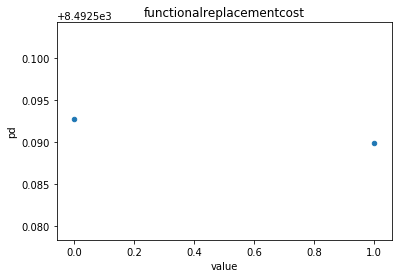

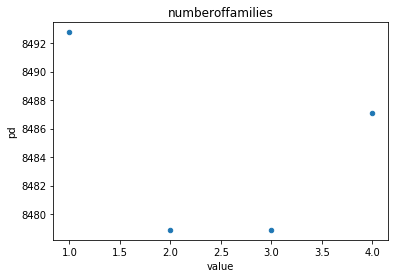

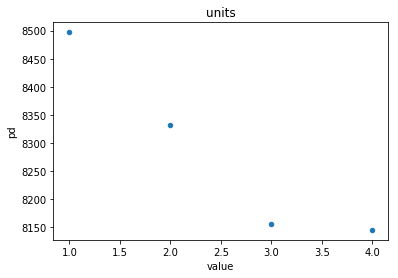

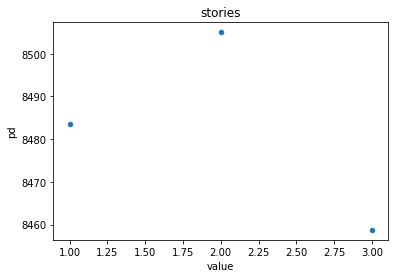

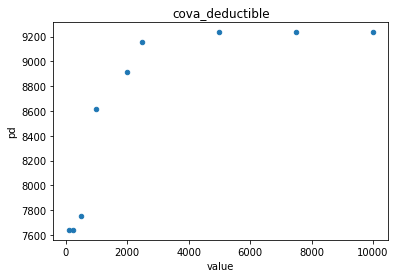

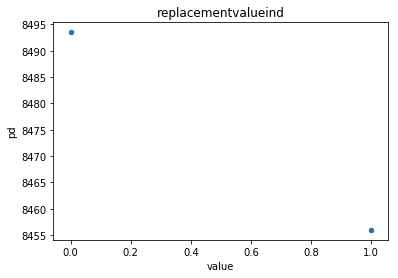

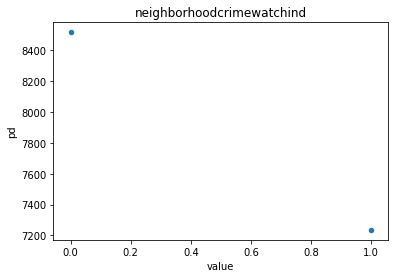

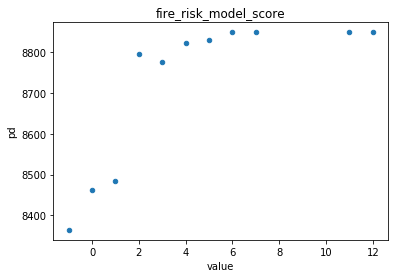

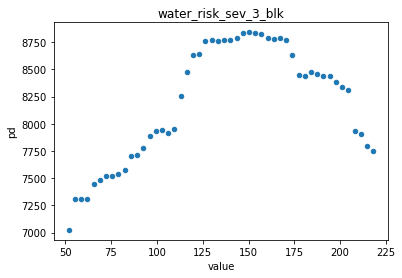

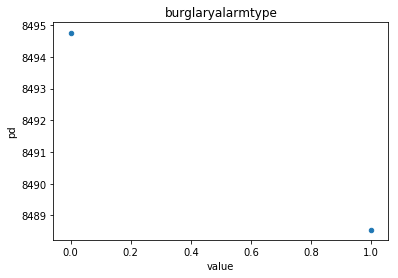

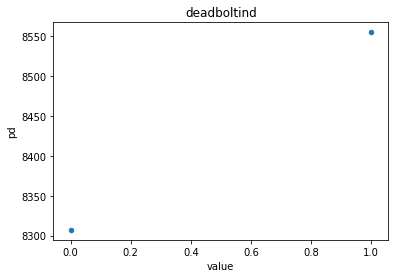

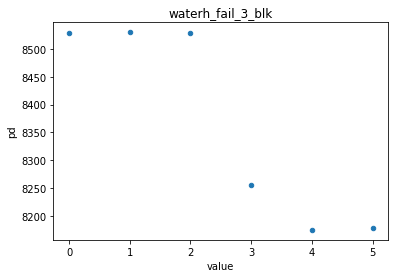

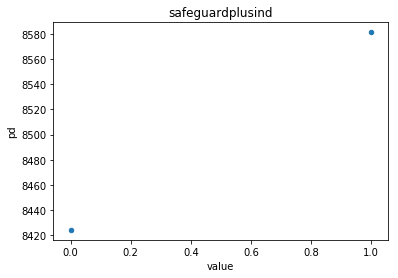

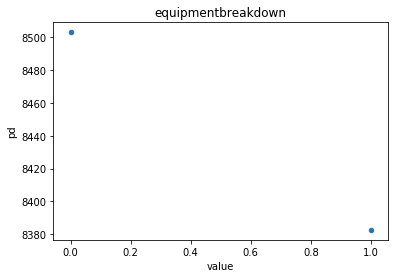

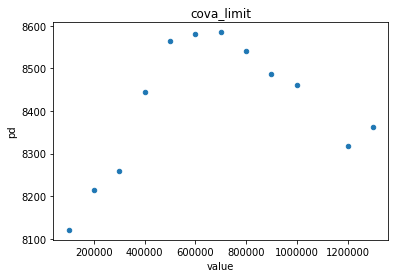

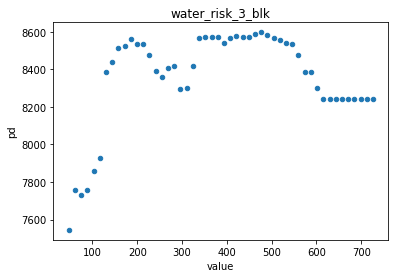

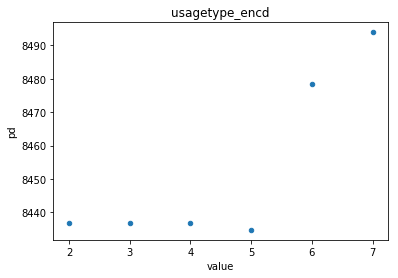

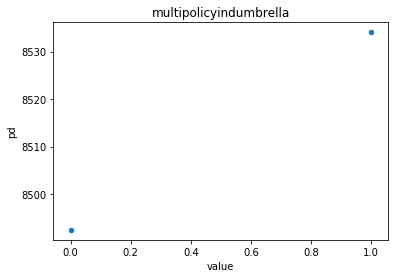

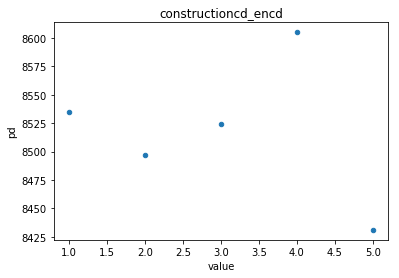

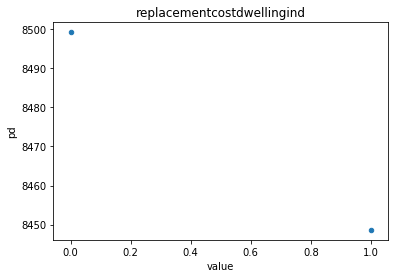

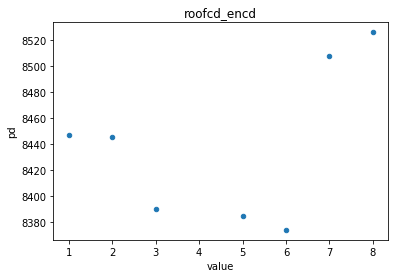

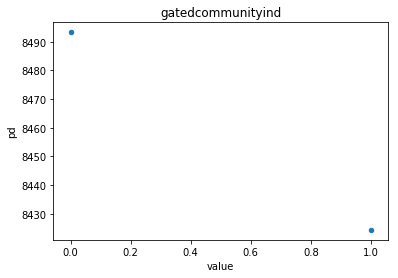

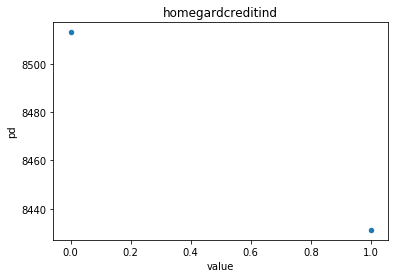

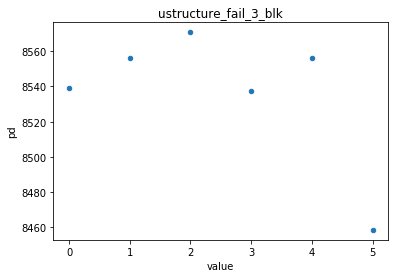

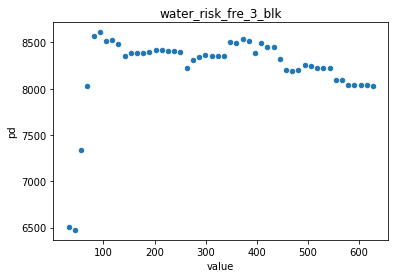

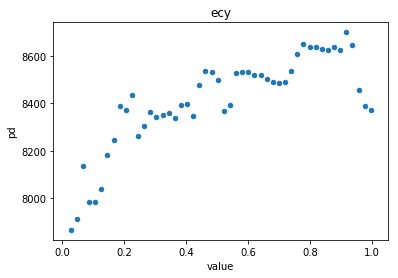

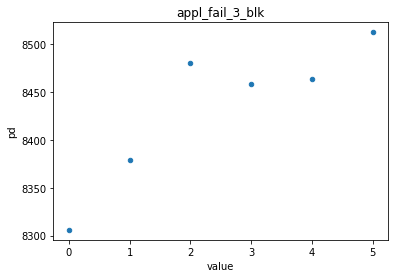

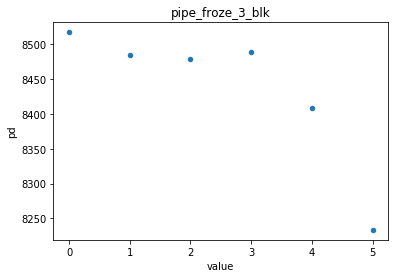

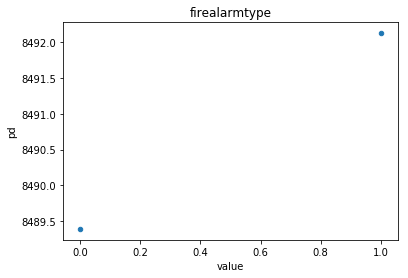

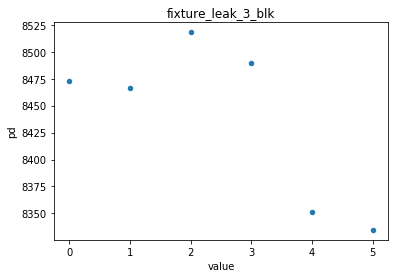

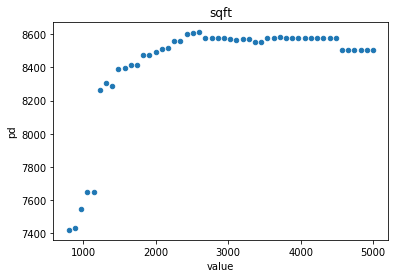

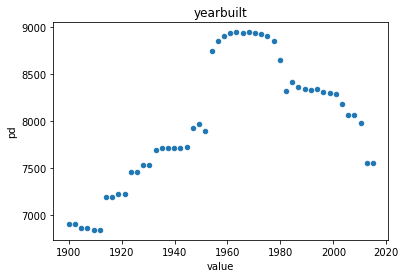

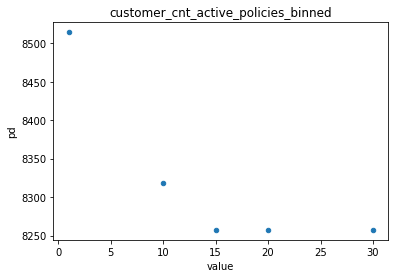

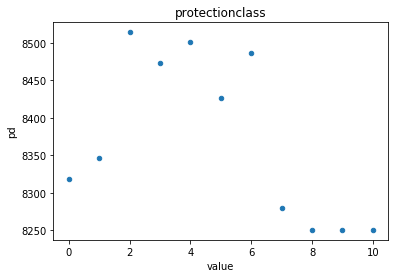

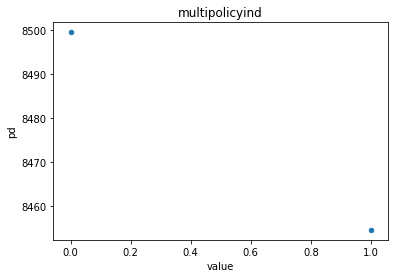

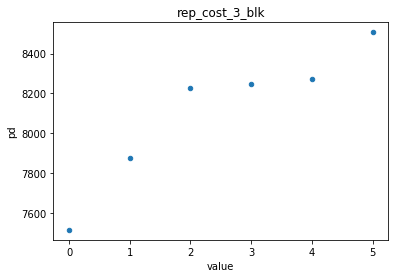

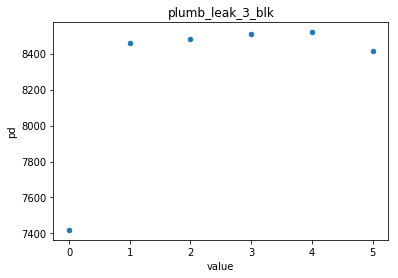

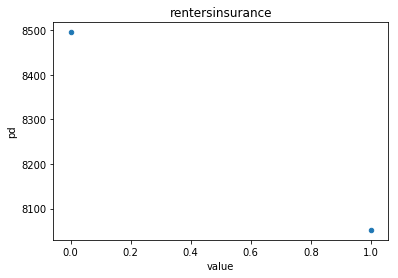

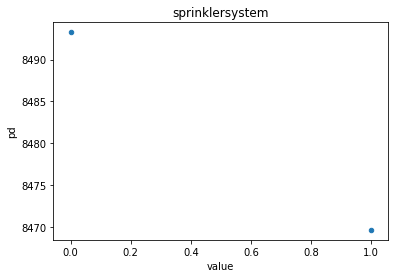

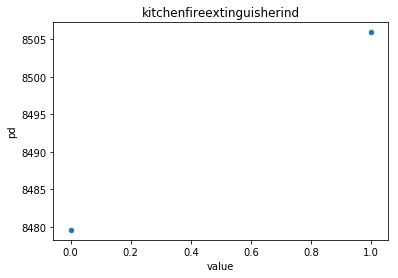

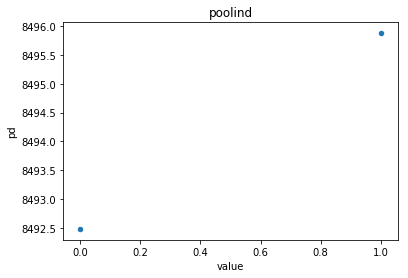

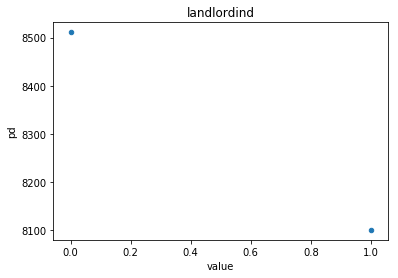

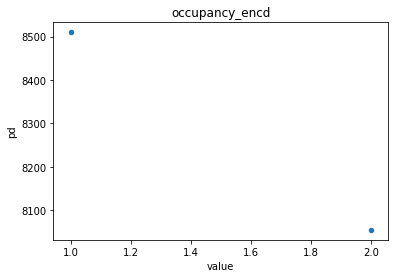

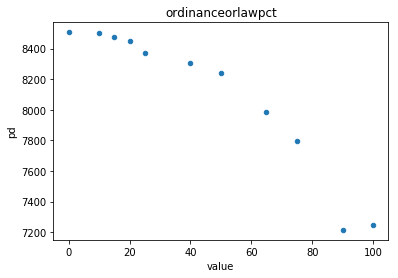

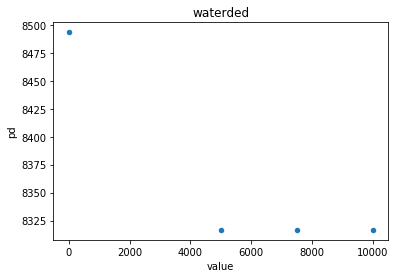

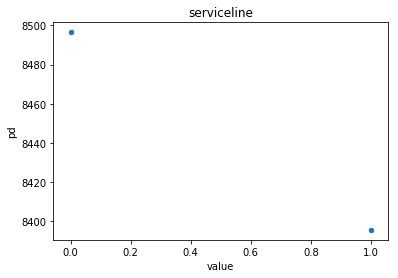

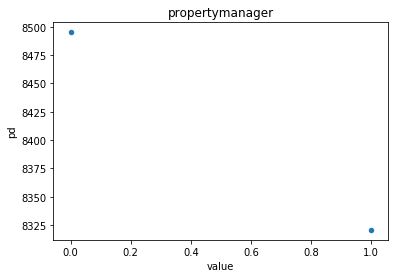

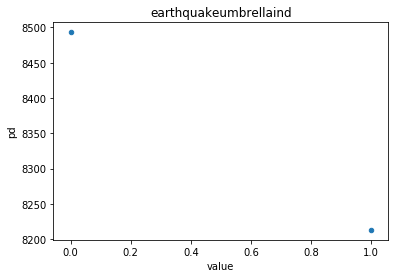

In [30]:
for f in pd_features:
    all_fm_pd[all_fm_pd['feature']==f].plot(kind='scatter',x='value', y='pd', title=f)

In [31]:
for f in pd_features:
    print(all_fm_pd[all_fm_pd['feature']==f])

   value           pd                    feature
0    0.0  8492.592773  functionalreplacementcost
1    1.0  8492.589844  functionalreplacementcost
   value           pd           feature
0    1.0  8492.752930  numberoffamilies
1    4.0  8487.075195  numberoffamilies
2    3.0  8478.901367  numberoffamilies
3    2.0  8478.901367  numberoffamilies
   value           pd feature
0    1.0  8497.088867   units
1    4.0  8144.883301   units
2    3.0  8156.194336   units
3    2.0  8332.265625   units
   value           pd  feature
0    1.0  8483.548828  stories
1    2.0  8505.031250  stories
2    3.0  8458.759766  stories
     value           pd          feature
0   1000.0  8615.696289  cova_deductible
1    500.0  7751.595703  cova_deductible
2    250.0  7642.566406  cova_deductible
3   2500.0  9159.107422  cova_deductible
4    100.0  7641.805664  cova_deductible
5   5000.0  9234.652344  cova_deductible
6  10000.0  9234.646484  cova_deductible
7   2000.0  8911.544922  cova_deductible
8   7500.0